# Segment Anything Model using `transformers` library

This notebook demonstrates how to use the Segment Anything Model (SAM) to segment objects in images. The model has been released by Meta AI in the paper [Segment Anything Model](https://ai.facebook.com/research/publications/segment-anything/). The original source code can be found [here](https://github.com/facebookresearch/segment-anything)

This notebook demonstrates how to use `transformers` to leverage the different usecases of the model. The examples are heavily inspired from the [original notebook of the authors](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb).

As stated by that notebook: 
> The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

## Install requirements

Let's first install the requirements. At this time of writing, the model is only available on the `main` branch of transformers. Hence you need to install `transformers` from source.

In [ ]:
!pip install git+https://github.com/ArthurZucker/transformers.git@add-sam

## Utility functions for display

These functions are entirely copied from the original notebook and they are useful for displaying the resulting segmentation masks, input points and bounding boxes if any.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## Load the model and processor

In [2]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-h").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-h")

/home/younes_huggingface_co/miniconda3/envs/fix-test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-19 10:54:00.073844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-19 10:54:00.073999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/loc

### Load the example image

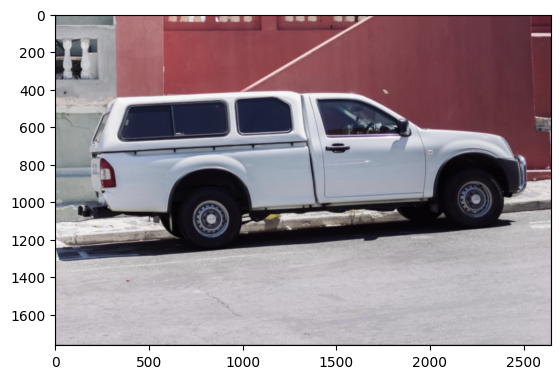

In [3]:
from PIL import Image
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

### Retrieve the image embeddings

Since we will compute several predictions on the same image, it is more efficient to compute the image embeddings once and for all.

In [4]:
inputs = processor(raw_image, return_tensors="pt").to(device)

image_embeddings = model.get_image_embeddings(**inputs)

## Pass a set of 2D points

You can pass a point, or a set of points to the model and get some predictions

The input points needs to have 3 dimensions, the first one being the number of input images (`batch_size`), the second being the number of points per image, and the third dimension being the xy coordinates of the points.

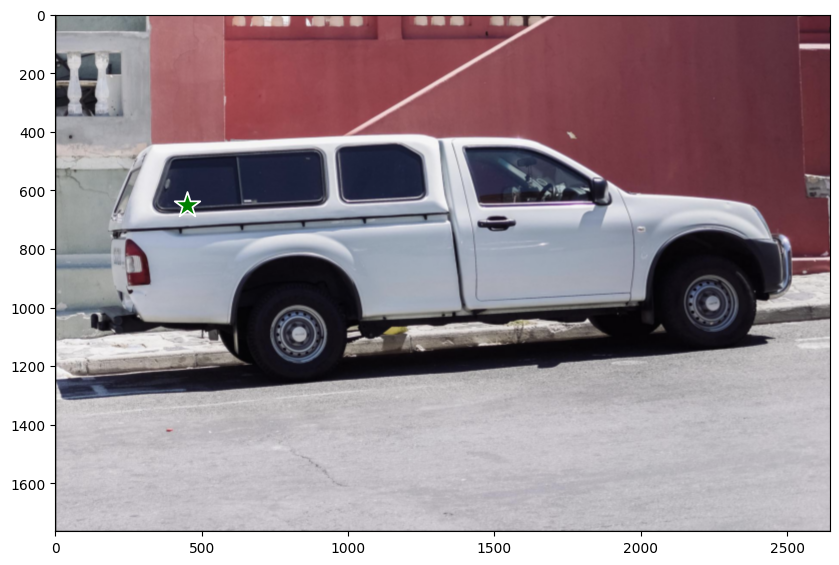

In [5]:
input_points = [[[450, 650]]]

plt.figure(figsize=(10,10))
plt.imshow(raw_image)
show_points(np.array(input_points[0]), np.array([1]), plt.gca())
plt.axis('on')
plt.show()

In [6]:

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /var/tmp/ipykernel_3870/2108964422.py:6 in <module>                                       │
│                                                                                           │
│ [Errno 2] No such file or directory: '/var/tmp/ipykernel_3870/2108964422.py'              │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'SamImageSegmentationOutput' object has no attribute 'low_resolution_masks'

In [8]:
masks = processor.post_process_masks(raw_image, outputs.pred_masks)


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /var/tmp/ipykernel_3870/2849915869.py:1 in <module>                                       │
│                                                                                           │
│ [Errno 2] No such file or directory: '/var/tmp/ipykernel_3870/2849915869.py'              │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'SamProcessor' object has no attribute 'post_process_masks'

In [ ]:
for i, (mask, score) in enumerate(zip(masks.squeeze(), outputs.iou_scores)):
    mask = mask.cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.array(raw_image))
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()